In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.6 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
import json
import cv2
import random as rnd
import time
import torch
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import copy
import math
import albumentations as A  # our data augmentation library

from collections import defaultdict, deque
import datetime
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2

from torchvision.ops import nms
from operator import itemgetter

import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Generator


In [3]:
SAMPLE_INDEX = 0
class DataHolder:
    def __init__(self, save_backgrounds=False, num_backgrounds=50):
        self.logos = self.logos = [[] for _ in range(len(LOGO_URLS))]
        self.source_bgs = list()
        self.bgs = list()
        self.target_size = (600, 600)
        self.save_backgrounds = save_backgrounds
        self.num_backgrounds = num_backgrounds

    def clean_train() -> None:
      for el in os.listdir('/content/dataset/train/images'):
        os.remove('/content/dataset/train/images/'+el)
      for el in os.listdir('/content/dataset/train/labels'):
          os.remove('/content/dataset/train/labels/'+el)

    def clean_val() -> None:
        for el in os.listdir('/content/dataset/val/images'):
            os.remove('/content/dataset/val/images/'+el)
        for el in os.listdir('/content/dataset/val/labels'):
            os.remove('/content/dataset/val/labels/'+el)

    def clean_test() -> None:
      for el in os.listdir('/content/dataset/test'):
        os.remove('/content/dataset/test/'+el)

    @staticmethod
    def resize_logo(logo: np.array, width = None, height = None, inter = cv2.INTER_AREA) -> np.array:
      dim = None
      (h, w) = logo.shape[:2]
      if width is None and height is None:
          return logo

      if width is None:
          r = height / float(h)
          dim = (int(w * r), height)
      else:
          r = width / float(w)
          dim = (width, int(h * r))

      resized = cv2.resize(logo, dim, interpolation = inter)
      return resized


    def prepare_data(self) -> None:
        for logo in LOGO_URLS:
            lg = cv2.imread(logo, cv2.IMREAD_UNCHANGED)
            f = logo[logo.rfind('/') + 1:]
            f = f.split('_')[0]
            self.logos[int(f)].append(self.resize_logo(lg, 150))
        for j in range(len(LOGO_URLS)):
            if not self.logos[j]:
                self.logos = self.logos[:j]
                break
        for bg in BG_URLS:
            back = cv2.imread(bg, cv2.IMREAD_UNCHANGED)
            back = cv2.cvtColor(back, cv2.COLOR_RGB2RGBA)
            self.source_bgs.append(back)
        counter = 0
        f = False
        for _ in range(self.num_backgrounds):
            for bg in self.source_bgs:
                self.generate_bg(bg)
                counter += 1
                if counter == self.num_backgrounds:
                  f = True
                  break
            if f:
              break

        if self.save_backgrounds:
            self.save_generated_backgrounds()

    def save_generated_backgrounds(self) -> None:
        for i, bg in enumerate(self.bgs):
            cv2.imwrite(f"/content/dataset/train/images/sample_{i}.png", bg)


    def generate_bg(self, source_bg: np.array) -> None:
      global SAMPLE_INDEX
      bgs = rnd.sample(self.source_bgs, 3)
      source_bg = cv2.resize(source_bg, self.target_size)
      for bg in bgs:
        scale = rnd.uniform(1.0, 2.5)
        scaled_background = cv2.resize(bg, (int(self.target_size[0] * scale), int(self.target_size[1] * scale)))
        angle = rnd.uniform(-60, 60)
        M = cv2.getRotationMatrix2D((self.target_size[0] / 2, self.target_size[1] / 2), angle, 1)
        rotated_background = cv2.warpAffine(scaled_background, M, self.target_size)
        x_offset = rnd.randint(0, self.target_size[0] - rotated_background.shape[1])
        y_offset = rnd.randint(0, self.target_size[1] - rotated_background.shape[0])
        mask = cv2.threshold(rotated_background, 0, 255, cv2.THRESH_BINARY)[1]
        alpha = rnd.uniform(0.3, 0.6)
        rotated_background_with_alpha = cv2.addWeighted(rotated_background, alpha, source_bg, 1 - alpha, 0)
        source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] = \
            source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] * (1 - mask / 255) + \
            rotated_background_with_alpha * (mask / 255)
      SAMPLE_INDEX += 1
      self.bgs.append(source_bg)

In [4]:
class ImageGenerator:
    def __init__(self, total_images, logos_per_bg_count=(0,2)):
        self.logos_per_bg_count = logos_per_bg_count
        self.total_images = total_images
        self.holder = DataHolder(num_backgrounds=self.total_images//2)
        self.holder.prepare_data()
        self.logos = self.holder.logos
        self.logos_per_image = math.ceil(self.total_images // len(self.logos))
        self.SAMPLE_INDEX_1 = 0
        self.images = []
        self.labels = []
        self.counter = [0 for _ in range(len(self.logos))]

    def main(self):
        for ind, lg in enumerate(self.logos):
            for i in range(self.logos_per_image):
                lst = []
                clss = []
                bg = rnd.choice(self.holder.bgs)
                t = rnd.randint(self.logos_per_bg_count[0], self.logos_per_bg_count[1])
                if t == 0:
                  self.images.append(np.copy(bg))
                  self.SAMPLE_INDEX_1 += 1
                  continue
                for j in range(t):
                    lg1 = 0
                    temp = 0
                    if j == 0:
                      temp = lg
                      lg1 = rnd.choice(lg)
                    else:
                      temp = rnd.choices(self.logos, weights=self.counter, k=1)[0]
                      lg1 = rnd.choice(temp)
                    clss.append(self.logos.index(temp))
                    for m in range(len(self.counter)):
                        if m != clss[-1]:
                            self.counter[m] += 1
                    lst.append(self.make_logo_roi(lg1, np.copy(bg), i + 1))
                self.make_sample(np.copy(bg), lst, clss, i + 1, self.SAMPLE_INDEX_1)
                self.SAMPLE_INDEX_1 += 1

    def make_sample(self, bg: np.array, rois: list, clss: list, sample: int, index: int):
        for roi in rois:
            duplicated_array = roi[4][:, :, 3][:, :, np.newaxis]
            result_array = np.tile(duplicated_array, 4)
            f = bg[roi[0] : roi[1], roi[2] : roi[3]] * ((255 - result_array) / 255) + roi[4] * (result_array / 255)
            bg[roi[0] : roi[1], roi[2] : roi[3]] = f

        if 0.15 * self.logos_per_image < sample < 0.25 * self.logos_per_image or 0.65 * self.logos_per_image < sample < 0.75 * self.logos_per_image:
            kernel_size = rnd.randint(5, 15)
            if kernel_size % 2 == 0:
                kernel_size += 1
            bg = cv2.GaussianBlur(bg, (kernel_size, kernel_size), 0)

        label = {
            'boxes': [],
            'labels': [],
            'image_id': [],
            'area': [],
            'iscrowd': []
        }
        for i, roi in enumerate(rois):

            '''x_center = ((roi[2] + roi[3]) / 2) / bg.shape[1]
            y_center = ((roi[0] + roi[1]) / 2) / bg.shape[0]
            norm_width = (roi[3] - roi[2]) / bg.shape[1]
            norm_height = (roi[1] - roi[0]) / bg.shape[0]
            label.append(f"{clss[i]} {x_center} {y_center} {norm_width} {norm_height}\n")'''
            label['boxes'].append([roi[2],roi[0],roi[3],roi[1]])
            label['labels'].append(clss[i]+1)
            label['image_id'].append(self.SAMPLE_INDEX_1)
            label['area'].append(bg.shape[0]*bg.shape[1])
            label['iscrowd'].append(0)

        label['boxes'] = torch.tensor(label['boxes'], dtype=torch.float32)
        label['labels'] = torch.tensor(label['labels'], dtype=torch.int64)
        label['image_id'] = torch.tensor(label['image_id'])
        label['area'] = torch.tensor(label['area'], dtype=torch.float32)
        label['iscrowd'] = torch.tensor(label['iscrowd'], dtype=torch.int64)

        self.labels.append(label)

        bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

        transform = T.Compose([
            T.ToTensor()
        ])

        self.images.append(transform(bg))

    def make_logo_roi(self, logo: np.array, bg: np.array, sample: int) -> tuple:
        logo = DataHolder.resize_logo(logo, rnd.randint(150, 350), cv2.IMREAD_UNCHANGED)
        logo = ImageGenerator.apply_random_color_distortion(logo)
        if sample < 0.6 * self.logos_per_image:
            logo = ImageGenerator.rotate_logo(logo, rnd.randint(-45, 45))
        logo = ImageGenerator.apply_random_perspective_distortion(logo)
        alpha_channel = logo[:, :, 3]

        # Добавление случайной прозрачности
        alpha_coefficient = rnd.uniform(0.3, 0.9)
        logo[:, :, 3] = (alpha_coefficient* logo[:, :, 3]).astype(np.uint8)
        alpha_channel = logo[:, :, 3]
        non_transparent_pixels = np.column_stack(np.where(alpha_channel > 0))
        min_x, max_x = np.min(non_transparent_pixels[:, 1]), np.max(non_transparent_pixels[:, 1])
        min_y, max_y = np.min(non_transparent_pixels[:, 0]), np.max(non_transparent_pixels[:, 0])
        logo = logo[min_y:max_y+1, min_x:max_x+1]
        bg = cv2.cvtColor(bg, cv2.COLOR_RGB2RGBA)
        x_offset, y_offset = rnd.randint(0, bg.shape[1] - logo.shape[1]), rnd.randint(0, bg.shape[0] - logo.shape[0])
        x_end, y_end = (x_offset + logo.shape[1], y_offset + logo.shape[0])


        return y_offset, y_end, x_offset, x_end, logo

    @staticmethod
    def rotate_logo(logo: np.array, angle: int) -> np.array:
        h, w = logo.shape[:2]
        img_c = (w / 2, h / 2)

        rot = cv2.getRotationMatrix2D(img_c, angle, 1)

        rad = np.radians(angle)
        sin = np.sin(rad)
        cos = np.cos(rad)
        b_w = int((h * abs(sin)) + (w * abs(cos)))
        b_h = int((h * abs(cos)) + (w * abs(sin)))

        rot[0, 2] += ((b_w / 2) - img_c[0])
        rot[1, 2] += ((b_h / 2) - img_c[1])

        outImg = cv2.warpAffine(logo, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
        return outImg

    @staticmethod
    def apply_random_color_distortion(image, max_shift=150):
        red_shift = rnd.randint(-max_shift, max_shift)
        green_shift = rnd.randint(-max_shift, max_shift)
        blue_shift = rnd.randint(-max_shift, max_shift)

        distorted_image = image.copy()
        distorted_image[:, :, 0] = np.clip(image[:, :, 0] + blue_shift, 0, 255)
        distorted_image[:, :, 1] = np.clip(image[:, :, 1] + green_shift, 0, 255)
        distorted_image[:, :, 2] = np.clip(image[:, :, 2] + red_shift, 0, 255)

        return distorted_image

    @staticmethod
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def apply_random_perspective_distortion(image, max_distortion=0.25):
        height, width, _ = image.shape
        points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
        x1 = 0
        y1 = 0
        x2 = width
        y2 = 0
        x3 = 0
        y3 = height
        x4 = width
        y4 = height


        offset_x1 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y1 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x2 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y2 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x3 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y3 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x4 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y4 = rnd.uniform(0, max_distortion) * image.shape[0]

        new_x1, new_y1 = x1 + offset_x1, y1 + offset_y1
        new_x2, new_y2 = x2 + offset_x2, y2 + offset_y2
        new_x3, new_y3 = x3 + offset_x3, y3 + offset_y3
        new_x4, new_y4 = x4 + offset_x4, y4 + offset_y4

        new_width = max(new_x1, new_x2, new_x3, new_x4)
        new_heigth = max(new_y1, new_y2, new_y3, new_y4)

        pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)

        distorted_image = cv2.warpPerspective(image, matrix, (int(new_width), int(new_heigth)))

        return distorted_image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
LOGO_URLS = ['/content/drive/MyDrive/logo_dataset/logos/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/logos/')]
BG_URLS = ['/content/drive/MyDrive/logo_dataset/backgrounds/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/backgrounds')]

In [7]:
# Один экземпляр генератора создает изображения с определенными параметрами (Например здесь 60 изображений, на каждом из которых от 0 до 2 логотипов включительно),
# для добавления например еще 100 картинок с 3 логотипами на каждом создается другой генератор ImageGenerator(100, (2, 2)) и так же вызывается метод main
generator = ImageGenerator(120, (1, 2))
generator.main()

#Load Dataset

In [8]:
class LazyDataset:
  def __init__(self, images, labels):
    self.images = images
    self.targets = labels
    self.ids = [i for i in range(len(labels))]

  def __getitem__(self,index):
    id = self.ids[index]
    image = self.images[id]
    target = self.targets[id]

    return image, target

  def __len__(self):
    return len(self.ids)

In [9]:
val_dataset = LazyDataset(generator.images, generator.labels)

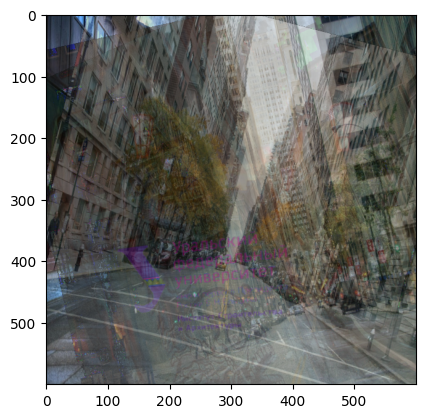

In [18]:
arrImg = val_dataset[200][0].numpy().transpose(1, 2, 0)
plt.imshow(arrImg)

In [19]:
val_dataset[200][1]

{'boxes': tensor([[115., 350., 394., 517.]]),
 'labels': tensor([5]),
 'image_id': tensor([200]),
 'area': tensor([360000.]),
 'iscrowd': tensor([0])}

# Train model

In [10]:
classes = ['mastercard','mir','unionpay','visa','urfu']

In [12]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(classes)+1)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [18]:
device = torch.device("cuda")
model = model.to(device)

In [19]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [20]:
def train_one_epoch(model, optimizer, device, epoch):
    model.to(device)
    model.train()


    generator = ImageGenerator(1000, (1, 2))
    generator.main()


    train_loader = DataLoader(LazyDataset(generator.images, generator.labels), batch_size=32, shuffle=True, collate_fn=collate_fn)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    return all_losses_dict

In [21]:
metric = MeanAveragePrecision(iou_type="bbox").to(device)

In [22]:
def val_one_epoch(model, val_loader):
  model.eval()


  for images, targets in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items() if k in ['boxes', 'labels']} for t in targets]

      with torch.no_grad():
          prediction = model(images)

      metric.update(prediction, targets)
      result = metric.compute()

  metric.reset()
  result_dict = pd.DataFrame(result) # for printing
  print("Validation: Epoch {}, lr: {:.6f}, mAP: {:.4f}, mAP50: {:.4f}, mAP75: {:.4f}".format(
      epoch, optimizer.param_groups[0]['lr'], result['map'], result['map_50'], result['map_75']
  ))
  return result

In [23]:
!nvidia-smi

Mon Dec 11 19:08:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    187MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
train_acc = []
val_acc = []
best_map_75 = 0.0
best_iter = 1
patience_dropLR = 10
dropLR_coef = 2
patience_earlyStop = 15

In [25]:
def dropLR(coef):
    optimizer.param_groups[0]['lr'] /= coef

In [26]:
def save_weights(model, epoch, save_path):
  torch.save(model.state_dict(), f'{save_path}/model_{epoch}_epochs.pth')

In [27]:
num_epochs = 50

for epoch in range(1, num_epochs+1):
    train_acc.append(train_one_epoch(model, optimizer, device, epoch))
    val_acc.append(val_one_epoch(model, val_loader))

    if val_acc[-1]['map_75']>best_map_75:
      best_map_75 = val_acc[-1]['map_75']
      best_iter = epoch
      save_weights(model, epoch, '.')

    if (epoch - best_iter) % patience_dropLR == 1:
      dropLR(dropLR_coef)

    if epoch - best_iter == patience_earlyStop:
       break

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


Epoch 1, lr: 0.001000, loss: 1.222992, loss_classifier: 0.672179, loss_box: 0.456180, loss_rpn_box: 0.013600, loss_object: 0.081033


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Validation: Epoch 1, lr: 0.001000, mAP: 0.0894, mAP50: 0.2605, mAP75: 0.0189


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Epoch 2, lr: 0.001000, loss: 1.138038, loss_classifier: 0.514802, loss_box: 0.577681, loss_rpn_box: 0.010954, loss_object: 0.034601


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Validation: Epoch 2, lr: 0.001000, mAP: 0.1957, mAP50: 0.3847, mAP75: 0.1718


100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


Epoch 3, lr: 0.001000, loss: 1.080319, loss_classifier: 0.505579, loss_box: 0.534324, loss_rpn_box: 0.010674, loss_object: 0.029741


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Validation: Epoch 3, lr: 0.001000, mAP: 0.3161, mAP50: 0.5990, mAP75: 0.3391


100%|██████████| 32/32 [00:33<00:00,  1.03s/it]


Epoch 4, lr: 0.001000, loss: 0.910464, loss_classifier: 0.442017, loss_box: 0.435159, loss_rpn_box: 0.009399, loss_object: 0.023889


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Validation: Epoch 4, lr: 0.001000, mAP: 0.4493, mAP50: 0.7304, mAP75: 0.5368


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch 5, lr: 0.001000, loss: 0.883822, loss_classifier: 0.419815, loss_box: 0.433946, loss_rpn_box: 0.008367, loss_object: 0.021694


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Validation: Epoch 5, lr: 0.001000, mAP: 0.5330, mAP50: 0.7962, mAP75: 0.6273


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Epoch 6, lr: 0.001000, loss: 0.840579, loss_classifier: 0.393595, loss_box: 0.414440, loss_rpn_box: 0.008900, loss_object: 0.023644


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Validation: Epoch 6, lr: 0.001000, mAP: 0.5637, mAP50: 0.8396, mAP75: 0.6789


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Epoch 7, lr: 0.001000, loss: 0.822304, loss_classifier: 0.380753, loss_box: 0.413955, loss_rpn_box: 0.008680, loss_object: 0.018916


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Validation: Epoch 7, lr: 0.001000, mAP: 0.6010, mAP50: 0.8723, mAP75: 0.7086


100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


Epoch 8, lr: 0.001000, loss: 0.705575, loss_classifier: 0.321154, loss_box: 0.359470, loss_rpn_box: 0.007519, loss_object: 0.017432


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Validation: Epoch 8, lr: 0.001000, mAP: 0.6153, mAP50: 0.8965, mAP75: 0.7248


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch 9, lr: 0.001000, loss: 0.742049, loss_classifier: 0.325841, loss_box: 0.392897, loss_rpn_box: 0.007566, loss_object: 0.015745


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


Validation: Epoch 9, lr: 0.001000, mAP: 0.6441, mAP50: 0.9173, mAP75: 0.7480


100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Epoch 10, lr: 0.001000, loss: 0.727892, loss_classifier: 0.317988, loss_box: 0.387704, loss_rpn_box: 0.006974, loss_object: 0.015227


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


Validation: Epoch 10, lr: 0.001000, mAP: 0.6541, mAP50: 0.9263, mAP75: 0.7872


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch 11, lr: 0.001000, loss: 0.747192, loss_classifier: 0.321265, loss_box: 0.403053, loss_rpn_box: 0.007020, loss_object: 0.015854


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


Validation: Epoch 11, lr: 0.001000, mAP: 0.6550, mAP50: 0.9319, mAP75: 0.7758


100%|██████████| 32/32 [00:31<00:00,  1.03it/s]


Epoch 12, lr: 0.000500, loss: 0.649602, loss_classifier: 0.287924, loss_box: 0.341706, loss_rpn_box: 0.006544, loss_object: 0.013429


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Validation: Epoch 12, lr: 0.000500, mAP: 0.6860, mAP50: 0.9337, mAP75: 0.8199


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 13, lr: 0.000500, loss: 0.656328, loss_classifier: 0.283685, loss_box: 0.352681, loss_rpn_box: 0.006840, loss_object: 0.013121


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Validation: Epoch 13, lr: 0.000500, mAP: 0.6996, mAP50: 0.9368, mAP75: 0.8194


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch 14, lr: 0.000250, loss: 0.629801, loss_classifier: 0.277909, loss_box: 0.333922, loss_rpn_box: 0.006338, loss_object: 0.011633


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Validation: Epoch 14, lr: 0.000250, mAP: 0.6936, mAP50: 0.9395, mAP75: 0.8027


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Epoch 15, lr: 0.000250, loss: 0.610300, loss_classifier: 0.260992, loss_box: 0.331759, loss_rpn_box: 0.006174, loss_object: 0.011375


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Validation: Epoch 15, lr: 0.000250, mAP: 0.7048, mAP50: 0.9416, mAP75: 0.8285


100%|██████████| 32/32 [00:30<00:00,  1.03it/s]


Epoch 16, lr: 0.000250, loss: 0.643444, loss_classifier: 0.275088, loss_box: 0.350010, loss_rpn_box: 0.006502, loss_object: 0.011845


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


Validation: Epoch 16, lr: 0.000250, mAP: 0.7074, mAP50: 0.9414, mAP75: 0.8269


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Epoch 17, lr: 0.000125, loss: 0.652045, loss_classifier: 0.281766, loss_box: 0.352263, loss_rpn_box: 0.006290, loss_object: 0.011725


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Validation: Epoch 17, lr: 0.000125, mAP: 0.7081, mAP50: 0.9398, mAP75: 0.8376


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 18, lr: 0.000125, loss: 0.661613, loss_classifier: 0.286375, loss_box: 0.354434, loss_rpn_box: 0.006382, loss_object: 0.014422


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Validation: Epoch 18, lr: 0.000125, mAP: 0.7020, mAP50: 0.9405, mAP75: 0.8226


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 19, lr: 0.000063, loss: 0.589401, loss_classifier: 0.248664, loss_box: 0.323193, loss_rpn_box: 0.006093, loss_object: 0.011451


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Validation: Epoch 19, lr: 0.000063, mAP: 0.7088, mAP50: 0.9404, mAP75: 0.8331


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 20, lr: 0.000063, loss: 0.631100, loss_classifier: 0.274334, loss_box: 0.336950, loss_rpn_box: 0.006431, loss_object: 0.013384


100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


Validation: Epoch 20, lr: 0.000063, mAP: 0.7101, mAP50: 0.9406, mAP75: 0.8253


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 21, lr: 0.000063, loss: 0.599131, loss_classifier: 0.261669, loss_box: 0.319885, loss_rpn_box: 0.006086, loss_object: 0.011491


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Validation: Epoch 21, lr: 0.000063, mAP: 0.7100, mAP50: 0.9412, mAP75: 0.8379


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 22, lr: 0.000063, loss: 0.628407, loss_classifier: 0.273338, loss_box: 0.337053, loss_rpn_box: 0.006699, loss_object: 0.011317


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Validation: Epoch 22, lr: 0.000063, mAP: 0.7111, mAP50: 0.9413, mAP75: 0.8391


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Epoch 23, lr: 0.000063, loss: 0.632143, loss_classifier: 0.272658, loss_box: 0.341622, loss_rpn_box: 0.005987, loss_object: 0.011876


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Validation: Epoch 23, lr: 0.000063, mAP: 0.7169, mAP50: 0.9424, mAP75: 0.8312


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 24, lr: 0.000031, loss: 0.640856, loss_classifier: 0.274527, loss_box: 0.348900, loss_rpn_box: 0.006338, loss_object: 0.011091


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Validation: Epoch 24, lr: 0.000031, mAP: 0.7155, mAP50: 0.9413, mAP75: 0.8349


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


Epoch 25, lr: 0.000031, loss: 0.656112, loss_classifier: 0.279035, loss_box: 0.359506, loss_rpn_box: 0.006513, loss_object: 0.011058


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Validation: Epoch 25, lr: 0.000031, mAP: 0.7096, mAP50: 0.9422, mAP75: 0.8297


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 26, lr: 0.000031, loss: 0.652302, loss_classifier: 0.277261, loss_box: 0.356182, loss_rpn_box: 0.006282, loss_object: 0.012576


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Validation: Epoch 26, lr: 0.000031, mAP: 0.7180, mAP50: 0.9412, mAP75: 0.8364


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 27, lr: 0.000031, loss: 0.636775, loss_classifier: 0.273474, loss_box: 0.346887, loss_rpn_box: 0.005876, loss_object: 0.010538


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


Validation: Epoch 27, lr: 0.000031, mAP: 0.7170, mAP50: 0.9435, mAP75: 0.8276


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Epoch 28, lr: 0.000031, loss: 0.657634, loss_classifier: 0.286273, loss_box: 0.351850, loss_rpn_box: 0.006264, loss_object: 0.013247


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Validation: Epoch 28, lr: 0.000031, mAP: 0.7172, mAP50: 0.9442, mAP75: 0.8364


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 29, lr: 0.000031, loss: 0.656514, loss_classifier: 0.282054, loss_box: 0.355459, loss_rpn_box: 0.006354, loss_object: 0.012647


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Validation: Epoch 29, lr: 0.000031, mAP: 0.7162, mAP50: 0.9419, mAP75: 0.8345


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 30, lr: 0.000031, loss: 0.651642, loss_classifier: 0.280786, loss_box: 0.352571, loss_rpn_box: 0.006160, loss_object: 0.012124


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Validation: Epoch 30, lr: 0.000031, mAP: 0.7133, mAP50: 0.9441, mAP75: 0.8367


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Epoch 31, lr: 0.000031, loss: 0.630372, loss_classifier: 0.274294, loss_box: 0.338739, loss_rpn_box: 0.006483, loss_object: 0.010856


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Validation: Epoch 31, lr: 0.000031, mAP: 0.7192, mAP50: 0.9412, mAP75: 0.8365


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 32, lr: 0.000031, loss: 0.633775, loss_classifier: 0.273764, loss_box: 0.342667, loss_rpn_box: 0.005829, loss_object: 0.011515


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Validation: Epoch 32, lr: 0.000031, mAP: 0.7132, mAP50: 0.9416, mAP75: 0.8259


100%|██████████| 32/32 [00:30<00:00,  1.07it/s]


Epoch 33, lr: 0.000031, loss: 0.632918, loss_classifier: 0.271257, loss_box: 0.345712, loss_rpn_box: 0.006203, loss_object: 0.009746


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Validation: Epoch 33, lr: 0.000031, mAP: 0.7168, mAP50: 0.9445, mAP75: 0.8425


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


Epoch 34, lr: 0.000031, loss: 0.648673, loss_classifier: 0.282735, loss_box: 0.348807, loss_rpn_box: 0.006564, loss_object: 0.010567


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


Validation: Epoch 34, lr: 0.000031, mAP: 0.7214, mAP50: 0.9424, mAP75: 0.8403


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 35, lr: 0.000016, loss: 0.647860, loss_classifier: 0.276365, loss_box: 0.354134, loss_rpn_box: 0.006204, loss_object: 0.011158


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Validation: Epoch 35, lr: 0.000016, mAP: 0.7165, mAP50: 0.9428, mAP75: 0.8383


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 36, lr: 0.000016, loss: 0.653503, loss_classifier: 0.280614, loss_box: 0.357173, loss_rpn_box: 0.005894, loss_object: 0.009822


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Validation: Epoch 36, lr: 0.000016, mAP: 0.7141, mAP50: 0.9422, mAP75: 0.8377


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 37, lr: 0.000016, loss: 0.641643, loss_classifier: 0.275892, loss_box: 0.346818, loss_rpn_box: 0.005982, loss_object: 0.012951


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Validation: Epoch 37, lr: 0.000016, mAP: 0.7161, mAP50: 0.9423, mAP75: 0.8375


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 38, lr: 0.000016, loss: 0.633156, loss_classifier: 0.271718, loss_box: 0.340706, loss_rpn_box: 0.006422, loss_object: 0.014311


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Validation: Epoch 38, lr: 0.000016, mAP: 0.7172, mAP50: 0.9424, mAP75: 0.8379


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 39, lr: 0.000016, loss: 0.656783, loss_classifier: 0.280877, loss_box: 0.359235, loss_rpn_box: 0.006166, loss_object: 0.010505


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Validation: Epoch 39, lr: 0.000016, mAP: 0.7187, mAP50: 0.9428, mAP75: 0.8385


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 40, lr: 0.000016, loss: 0.617499, loss_classifier: 0.263116, loss_box: 0.334461, loss_rpn_box: 0.006044, loss_object: 0.013878


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Validation: Epoch 40, lr: 0.000016, mAP: 0.7191, mAP50: 0.9431, mAP75: 0.8410


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 41, lr: 0.000016, loss: 0.653663, loss_classifier: 0.281374, loss_box: 0.355987, loss_rpn_box: 0.006362, loss_object: 0.009940


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Validation: Epoch 41, lr: 0.000016, mAP: 0.7212, mAP50: 0.9423, mAP75: 0.8348


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 42, lr: 0.000016, loss: 0.636000, loss_classifier: 0.269408, loss_box: 0.350549, loss_rpn_box: 0.005784, loss_object: 0.010260


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Validation: Epoch 42, lr: 0.000016, mAP: 0.7222, mAP50: 0.9431, mAP75: 0.8411


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 43, lr: 0.000016, loss: 0.623647, loss_classifier: 0.267123, loss_box: 0.339778, loss_rpn_box: 0.006325, loss_object: 0.010421


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Validation: Epoch 43, lr: 0.000016, mAP: 0.7270, mAP50: 0.9431, mAP75: 0.8412


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 44, lr: 0.000016, loss: 0.641850, loss_classifier: 0.275468, loss_box: 0.349496, loss_rpn_box: 0.006256, loss_object: 0.010630


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Validation: Epoch 44, lr: 0.000016, mAP: 0.7182, mAP50: 0.9428, mAP75: 0.8409


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 45, lr: 0.000008, loss: 0.636966, loss_classifier: 0.268982, loss_box: 0.349307, loss_rpn_box: 0.006337, loss_object: 0.012340


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Validation: Epoch 45, lr: 0.000008, mAP: 0.7195, mAP50: 0.9423, mAP75: 0.8374


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Epoch 46, lr: 0.000008, loss: 0.658825, loss_classifier: 0.281668, loss_box: 0.358534, loss_rpn_box: 0.006370, loss_object: 0.012252


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Validation: Epoch 46, lr: 0.000008, mAP: 0.7214, mAP50: 0.9428, mAP75: 0.8410


100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


Epoch 47, lr: 0.000008, loss: 0.629048, loss_classifier: 0.267514, loss_box: 0.343477, loss_rpn_box: 0.006109, loss_object: 0.011948


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Validation: Epoch 47, lr: 0.000008, mAP: 0.7201, mAP50: 0.9429, mAP75: 0.8386


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 48, lr: 0.000008, loss: 0.611669, loss_classifier: 0.260375, loss_box: 0.331708, loss_rpn_box: 0.006120, loss_object: 0.013465


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

Validation: Epoch 48, lr: 0.000008, mAP: 0.7189, mAP50: 0.9425, mAP75: 0.8354


<Axes: xlabel='Epochs', ylabel='Score'>

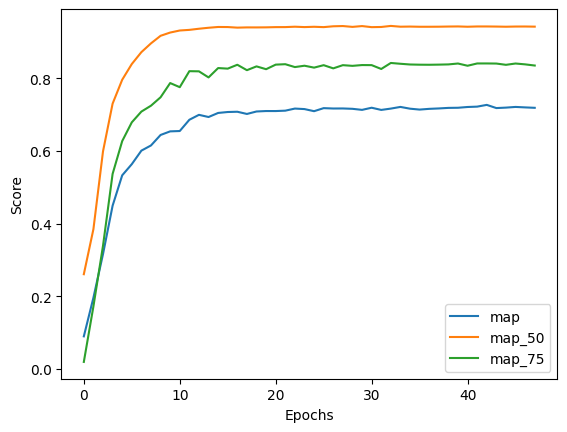

In [29]:
val_scores_df =pd.DataFrame(val_acc)
val_scores_df['map'] = val_scores_df['map'].astype(float)
val_scores_df['map_50'] = val_scores_df['map_50'].astype(float)
val_scores_df['map_75'] = val_scores_df['map_75'].astype(float)
val_scores_df.plot(y=["map", "map_50", "map_75"], xlabel='Epochs', ylabel='Score')

In [ ]:
def NMS()

# Predict on real data

In [ ]:
def load_test_data(images_path, classes, transform, collate_fn, batch_size):
  test_dataset = LogoDetection(root='.', split=images_path, transforms=transform)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  return next(iter(test_loader))

In [ ]:
def pred_with_nms(model, image, iou_threshold):
  pred = model([image.to(device)])
  nms_idx = nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold)
  nms_pred = {
    'boxes': itemgetter(nms_idx)(pred[0]['boxes']),
    'labels': itemgetter(nms_idx)(pred[0]['labels']),
    'scores': itemgetter(nms_idx)(pred[0]['scores'])
  }
  prediction = [dict(
              boxes=nms_pred['boxes'].to('cpu'),
              scores=nms_pred['scores'].to('cpu'),
              labels=nms_pred['labels'].to('cpu')
             )]

  return prediction

In [ ]:
classes = ['tinkoff', 'naumen', 'ussc', 'rostelecom', 'sber', 'gosuslugi']

In [ ]:
transform = A.Compose([ToTensorV2()], bbox_params=A.BboxParams(format='coco'))

In [ ]:
images, labels = load_test_data("./dataset/test/images", classes, transform, collate_fn, 32)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
device = torch.device("cuda")
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn() # we do not specify ``weights``, i.e. create untrained model
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 7)
model.load_state_dict(torch.load('./model_25_epochs.pth'))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
#predicts loop
metric = MeanAveragePrecision(iou_type="bbox")

for i in range(len(images)):
  target = [dict(
          boxes=labels[i]['boxes'],
          labels=labels[i]['labels']
         )]
  prediction = pred_with_nms(model, images[i], 0.05)

  metric.update(prediction, target)

print(metric.compute())
metric.reset()

{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5, 6], dtype=torch.int32)}


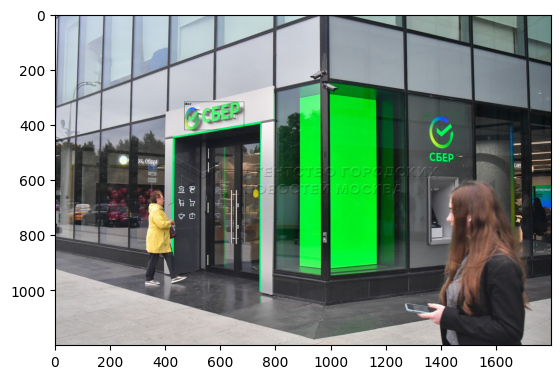

In [ ]:
plt.imshow(draw_bounding_boxes(torch.tensor(images[0]*255, dtype=torch.uint8),  labels[0]['boxes'], [classes[i-1] for i in labels[0]['labels'].tolist()]).permute(1,2,0))

In [ ]:
nms_pred = pred_with_nms(model, images[0], 0.05)

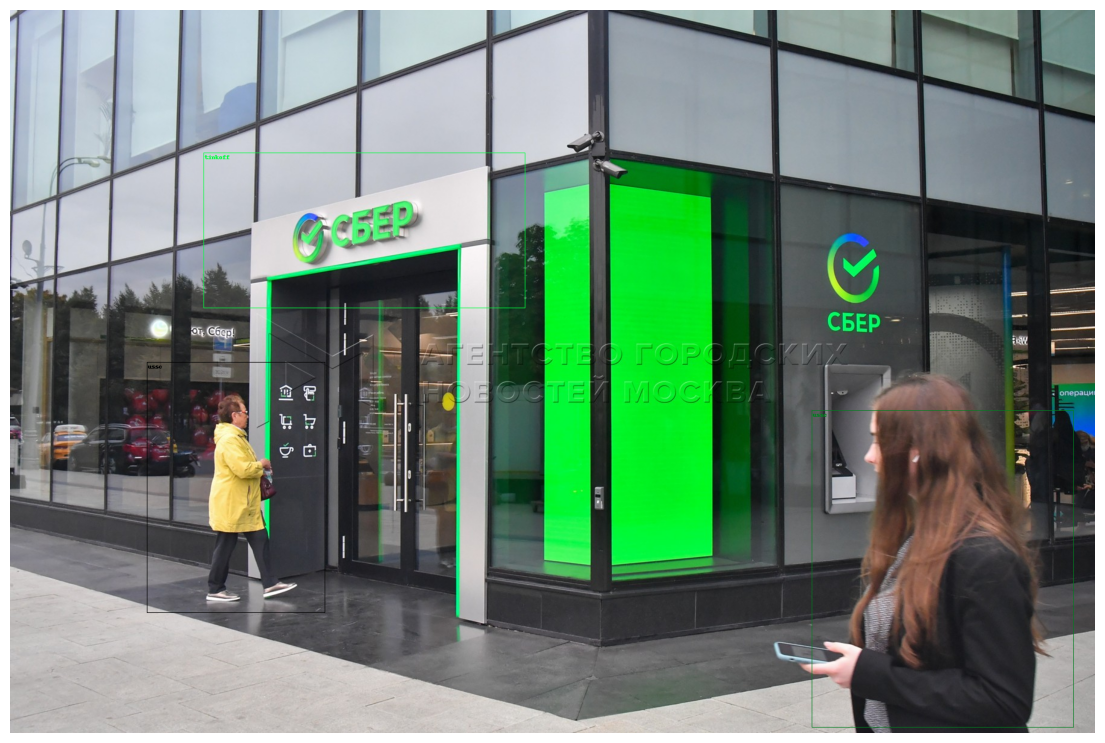

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.axis('off')
plt.imshow(draw_bounding_boxes(torch.tensor(images[0]*255, dtype=torch.uint8),  nms_pred[0]['boxes'], [classes[i-1] for i in nms_pred[0]['labels'].tolist()]).permute(1,2,0))

In [ ]:
torch.cuda.empty_cache()

# Predict on sample Images

In [30]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [32]:
#load weights to model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn() # we do not specify ``weights``, i.e. create untrained model
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(classes)+1)
model.load_state_dict(torch.load('/content/model_33_epochs.pth'))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [58]:
def NMS(bboxes, scores, thresh=0.5):
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    # Calculate the area of ​​each box
    areas = (x2 - x1 + 1)*(y2 - y1 + 1)
    # Sort the scores in descending order, and order is the index in descending order
    _, order = scores.sort(0, descending=True)
    # keep keep the bbox left by nms
    keep =[]
    while order.numel() > 0:
        if order.numel() == 1:  # There is only one reserved box
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0].item() # Keep the box with the largest scores
            keep.append(i)

        xx1 = x1[order[1:]].clamp(min=x1[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(min=x2[i])
        yy2 = y2[order[1:]].clamp(min=y2[i])
        # Find the area of ​​the overlapping part of each box with the current box
        inter = (xx2 - xx1).clamp(min = 0)*(yy2 -yy1).clamp(min=0)
        # Calculate the IOU of each box and the current box
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        # Keep the border index with IOU less than the threshold
        idx = (iou <= thresh).nonzero().squeeze()
        if idx.numel() == 0:
            break
        order = order[idx + 1]
    return torch.LongTensor(keep)

In [70]:
def single_image_prediction(image_path: str, save_path: str, thresh: float) -> None:
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  transform = T.Compose([
      T.ToTensor()
  ])
  tensor = transform(image)

  img_int = torch.tensor(tensor*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([tensor.to(device)])
      pred = prediction[0]

  nms = NMS(pred['boxes'],pred['scores'], thresh)

  fig = plt.figure(figsize=(14, 10))
  plt.axis('off')
  plt.rcParams.update({'font.size': 26})
  plt.imshow(draw_bounding_boxes(img_int,
      pred['boxes'][nms],
      [classes[i-1] for i in pred['labels'][nms].tolist()], width=4,font_size=48,
      colors="green"
  ).permute(1, 2, 0))
  plt.savefig(save_path, bbox_inches='tight', pad_inches = 0)

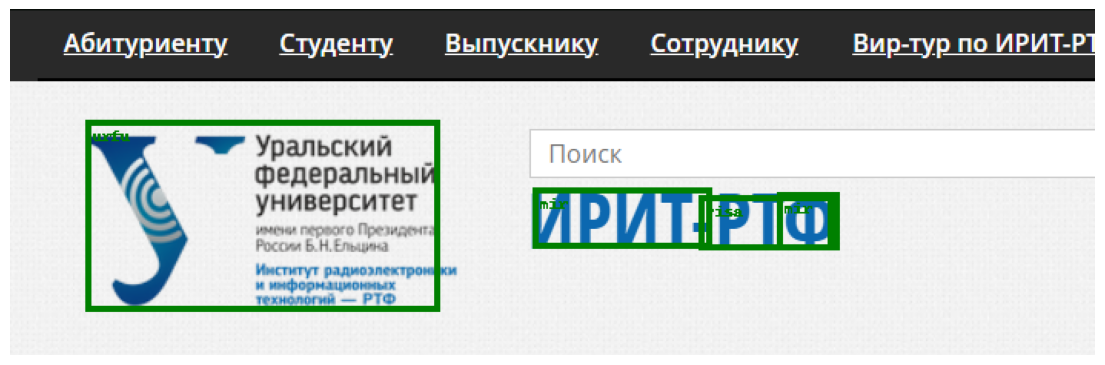

In [81]:
single_image_prediction('/content/Снимок экрана 2023-12-12 012854.png','_predict.png', 0.75)

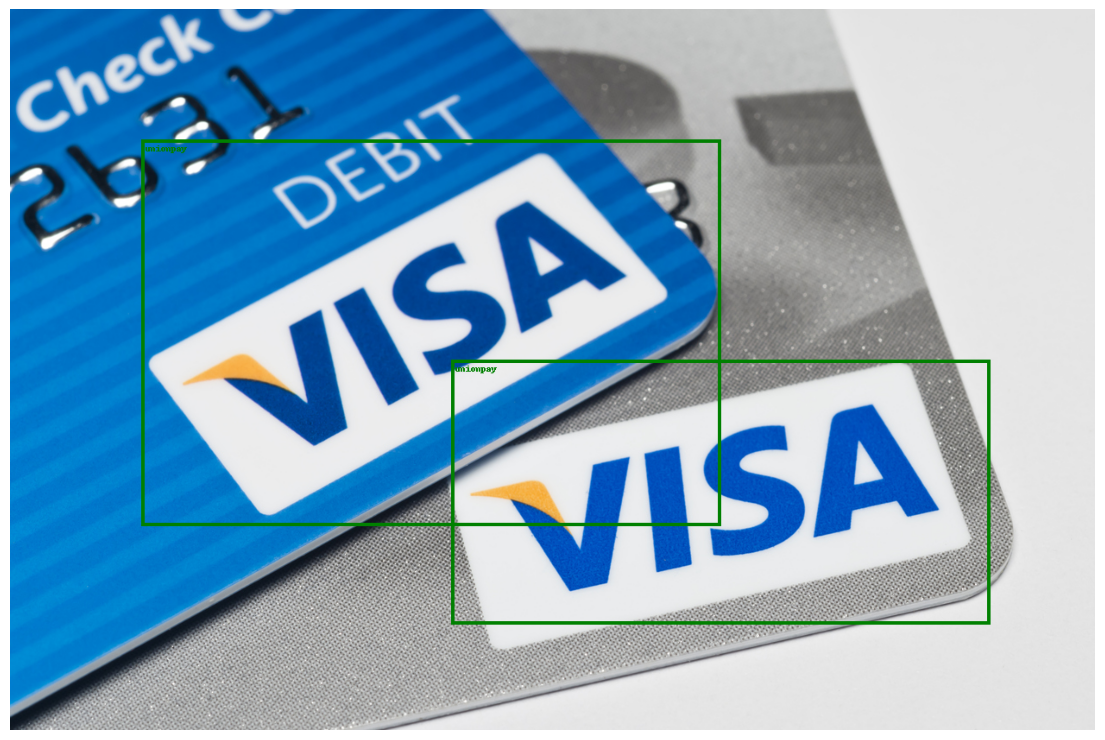

In [77]:
single_image_prediction('/content/image_2023-11-21_00-12-52.png','_predict.png', 0.75)

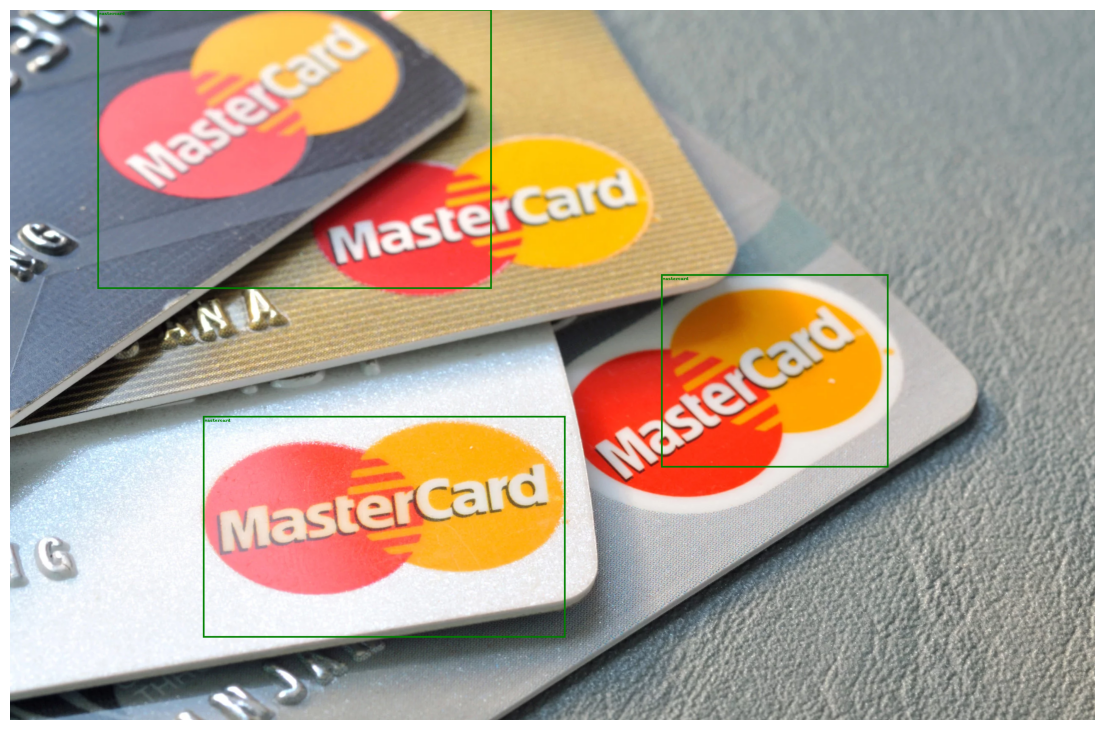

In [83]:
single_image_prediction('/content/image_2023-11-21_00-12-54.png','_predict.png', 0.75)

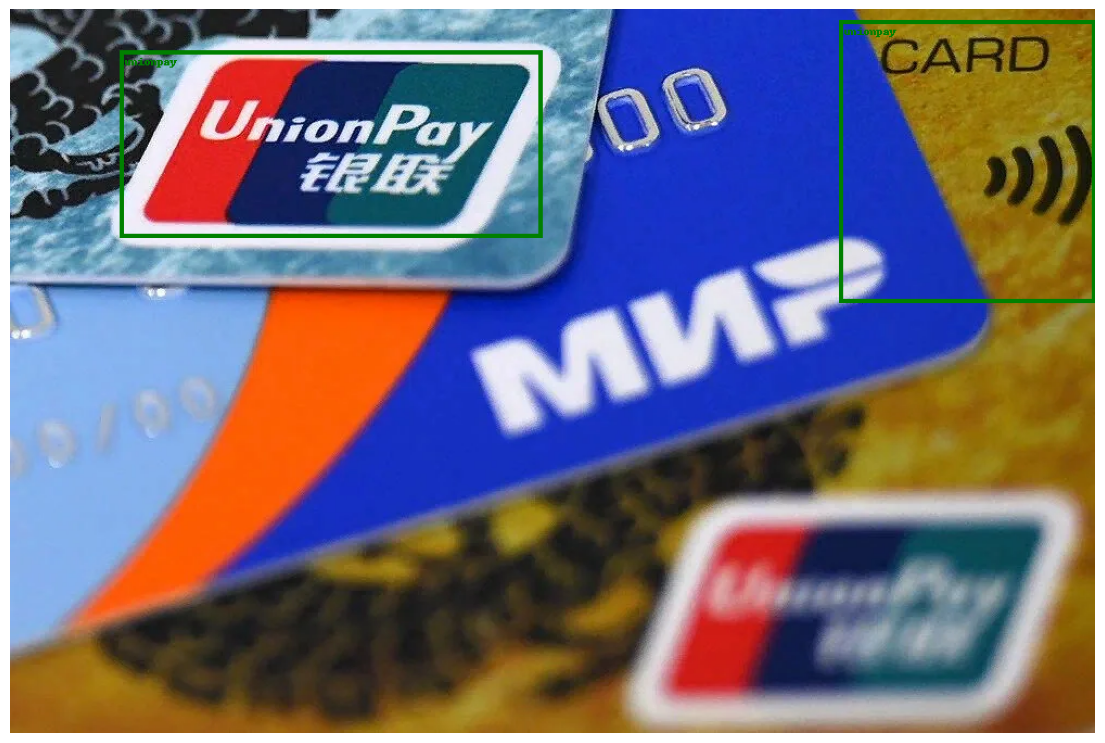

In [88]:
single_image_prediction('/content/image_2023-11-21_00-12-57.png','_predict.png', 0.75)

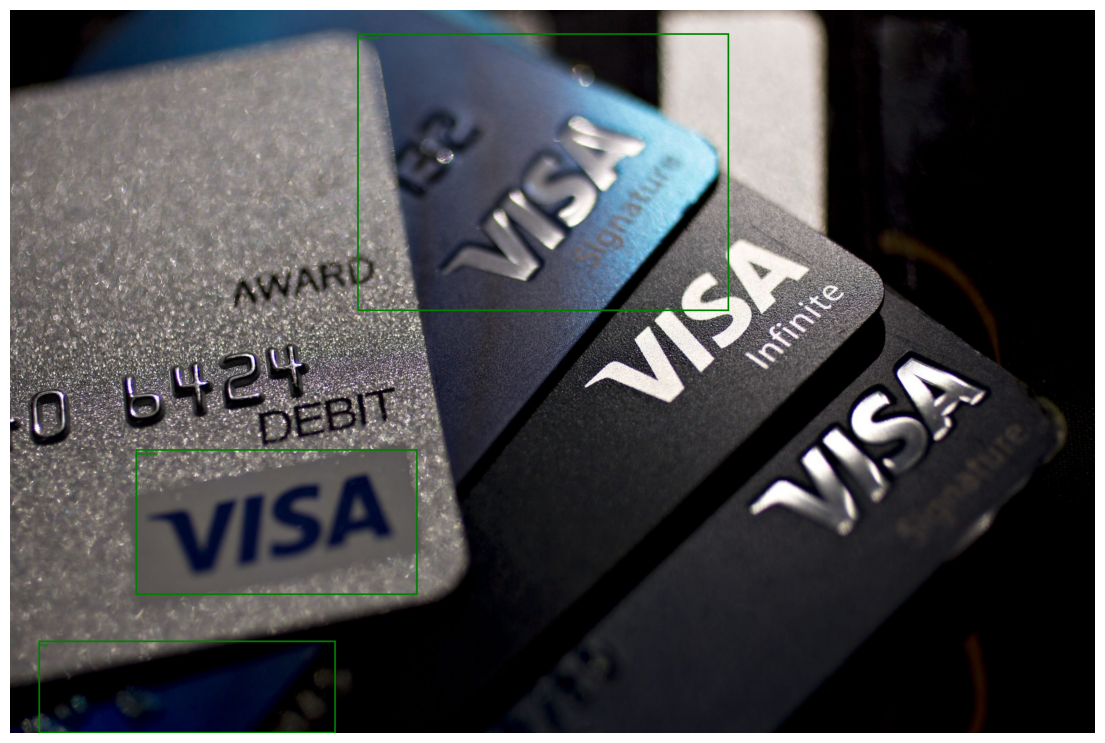

In [98]:
single_image_prediction('/content/1636161795_47-papik-pro-p-visa-logotip-foto-51.jpg','_predict.png', 0.75)

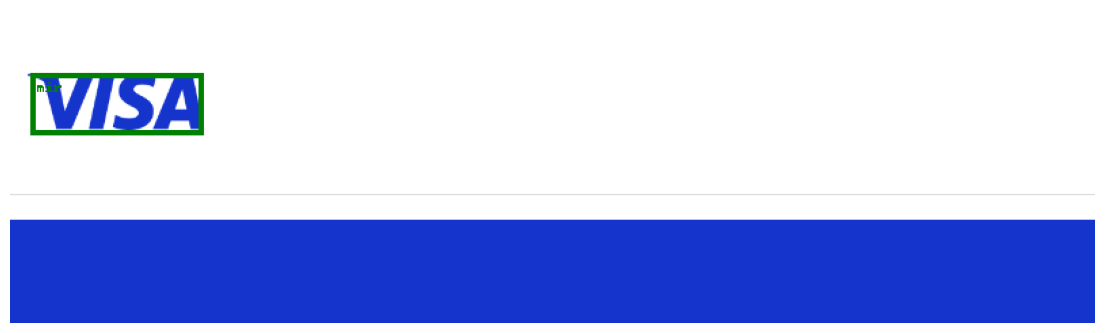

In [121]:
single_image_prediction('/content/Снимок экрана 2023-12-12 020707.png','_predict.png', 0.75)